# Generate initial state

In [1]:
import mode_analysis_code

In [8]:
mode_analysis = mode_analysis_code.ModeAnalysis(N=127, Vwall=1, frot=180)

In [9]:
mode_analysis.run()

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

## Axial energy eigenvalues

In [11]:
mode_analysis.axialEvals

array([ 0.87260481,  0.87327645,  0.87597129,  0.87861162,  0.87924613,
        0.88033972,  0.88082993,  0.88430479,  0.88498056,  0.88520925,
        0.88556241,  0.88566701,  0.88582929,  0.88894908,  0.88962417,
        0.89079234,  0.89146112,  0.89276869,  0.89304087,  0.89365991,
        0.89425333,  0.89554436,  0.8967272 ,  0.89758566,  0.89930768,
        0.89950648,  0.90022893,  0.90156418,  0.90392892,  0.90453344,
        0.90462005,  0.90497968,  0.90614437,  0.90629316,  0.90670187,
        0.9070171 ,  0.90743804,  0.90873487,  0.90965961,  0.91083413,
        0.91202336,  0.91225251,  0.91344168,  0.91417398,  0.91447469,
        0.91521208,  0.91746349,  0.91778963,  0.91844314,  0.91963653,
        0.9215479 ,  0.92192291,  0.92389062,  0.92406465,  0.92489981,
        0.92607399,  0.92635456,  0.92674312,  0.92698995,  0.9271965 ,
        0.92816205,  0.92848228,  0.9288292 ,  0.93039849,  0.9309064 ,
        0.93195154,  0.93207771,  0.93352554,  0.93354168,  0.93

<IPython.core.display.Javascript object>


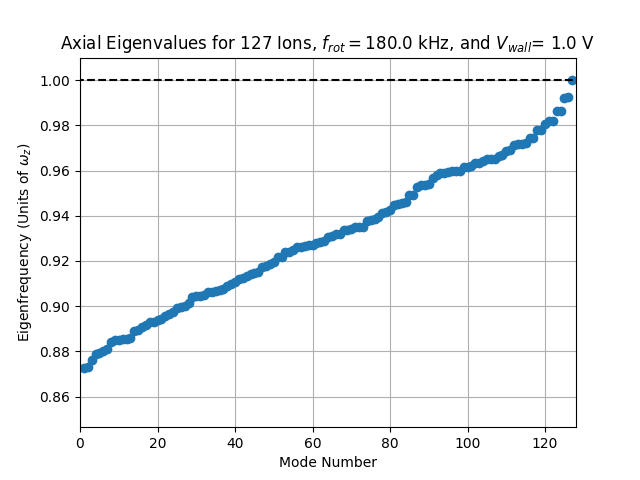

In [19]:
mode_analysis.show_axial_Evals();

As part of the mode_analysis.run() call the positions of the ions in the rest frame have been calculated and stored in u. Here they are:

<IPython.core.display.Javascript object>


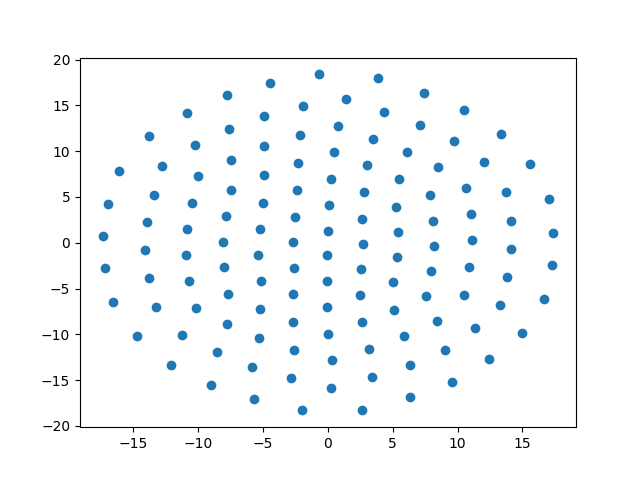

In [17]:
plt.figure()
plt.plot(mode_analysis.u[:127], mode_analysis.u[127:],'o')

# Units

Most calcualtions are done in a dimensionless system of units. Conversion to dimensionless and experimental form are done with the following two methods:

```
    def dimensionless(self):
        """Calculate characteristic quantities and convert to a dimensionless
        system
        """
        # characteristic length
        self.l0 = ((self.k_e * self.q ** 2) / (.5 * self.m_Be * self.wz ** 2)) ** (1 / 3)
        self.t0 = 1 / self.wz  # characteristic time
        self.v0 = self.l0 / self.t0  # characteristic velocity
        self.E0 = 0.5*self.m_Be*(self.wz**2)*self.l0**2 # characteristic energy
        self.wr = self.wrot / self.wz  # dimensionless rotation
        self.wc = self.wcyc / self.wz  # dimensionless cyclotron
        self.md = self.m / self.m_Be  # dimensionless mass

    def expUnits(self):
        """Convert dimensionless outputs to experimental units"""
        self.u0E = self.l0 * self.u0  # Seed lattice
        self.uE = self.l0 * self.u  # Equilibrium positions
        self.axialEvalsE = self.wz * self.axialEvals
        self.planarEvalsE = self.wz * self.planarEvals
        # eigenvectors are dimensionless anyway
```

Apparently the characteristic length is
$
l_0 = \left(\frac{q^2}{4\pi\epsilon_0}/(m \omega_z^2/2)\right)^{1/3}
$
Not quite sure what the meaning of this length scale is.


## Trap potential

The `ModeAnalysis.__init__()` method takes a parameter `Vtrap` that specifies the electrostatic potentials as far as I can tell. A comment in the source code suggests that the three components of this vector are the voltages on the end, middle, and center trap electrodes. Presumably these are in Volts. Inside `__init__()` we then calculate 0th, first, second, and fourth order moments of the trap potential at the center of the trap from the voltages. These are compute using a 4x3 matrix that is explained in "Teale's final paper". The result is stored in `self.Coeff`. The axial trap frequency is computed from this as follows:
$$
\omega_z=\sqrt{2 q {\tt self.Coeff[2]} / m}
$$
So this suggests that `self.Coeff[2]` corresponds to what I've been calling $k_z$.

A "wall potential" of $V_{\rm wall}=5$ is translated into a coefficient ${\tt self.Cw2} = q V_{\rm wall} 1612$. Apparently this is not used anymore. Instead, we use the parameter ${\tt self.Cw} = 1612 V_{\rm wall} / V_0$ where $V_0 = 1/2 m \omega_z^2 / q$ which really reduces to ${\tt self.Coeff[2]}$. I think this make `self.Cw` equivalent with the parameter $\delta$ I've been using up to perhaps a factor of 2 which I need to check on. The stronger axis of the trap is along $x$, the weaker axis is along $y$.

Apparently we are using a trap rotation frequency of $180 {\rm kHz}$ by default.

The default axial magnetic field is $B_z=4.4588T$.


## Positions

In [20]:
mode_analysis.Cw

0.00033752977203130319

In [ ]:
mode_analysis.expUnits()

<IPython.core.display.Javascript object>


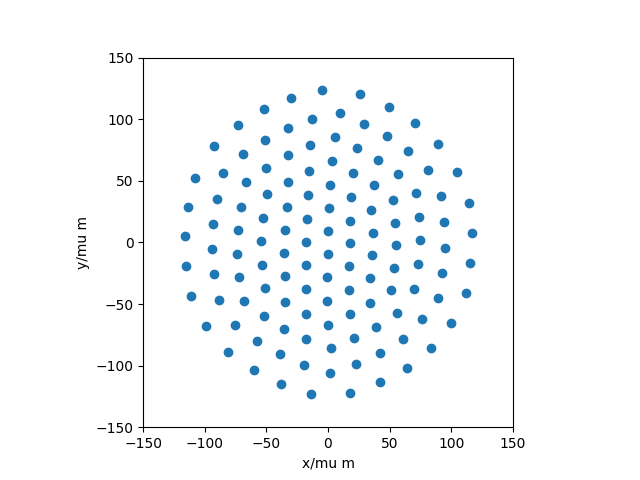

In [24]:
plt.figure()
plt.plot(1.0e6 * mode_analysis.uE[:127], 1.0e6 * mode_analysis.uE[127:], 'o');
plt.xlabel('x/mu m')
plt.ylabel('y/mu m')
rmax = 150.0
for l in [plt.xlim, plt.ylim]:
    l([-rmax, rmax])
plt.gca().set_aspect(1)

# parameters for simulation

In [30]:
print(mode_analysis.Cw)
print(mode_analysis.wrot)
print(mode_analysis.Coeff)
print(mode_analysis.wz)

0.000337529772031
1130973.3552923256
[ -1.71987500e+03  -1.25000000e+00   4.77587500e+06   1.89000000e+08]
10112373.2322


# Simulation

In [32]:
import coldatoms

In [68]:
def create_ensemble(uE, omega_z):
    num_ions = int(uE.size / 2)
    x = uE[:num_ions]
    y = uE[num_ions:]
    r = np.sqrt(x**2 + y**2)
    r_hat = np.transpose(np.array([x / r, y / r]))
    phi_hat = np.transpose(np.array([-y / r, x / r]))
    v = omega_z * (r[:, np.newaxis] * phi_hat)
    
    ensemble = coldatoms.Ensemble(num_ions)
    ensemble.x[:, 0] = x
    ensemble.x[:, 1] = y
    ensemble.x[:, 2] = np.zeros(num_ions)
    ensemble.v[:, 0] = v[:, 0]
    ensemble.v[:, 1] = v[:, 1]
    ensemble.v[:, 2] = np.zeros(num_ions)
    
    return ensemble

In [70]:
ensemble = create_ensemble(mode_analysis.uE, mode_analysis.wrot)

In [71]:
print(ensemble.x[:,0])

[  1.80203727e-05   1.78564950e-05   5.48542682e-05   3.56903018e-05
   1.69055080e-05  -1.78580680e-05  -3.52201305e-05   1.67937057e-06
   2.03782933e-05   1.86758554e-05   5.35685786e-05   5.07484976e-05
   1.67012848e-05  -5.85240270e-07  -1.78844873e-05  -3.47164671e-05
  -5.42511642e-05  -3.33558436e-05  -1.60574406e-05  -1.67491980e-05
   2.34419491e-05   3.70000354e-05   3.61668935e-05   5.45609929e-05
   7.44425210e-05   3.37301865e-05   5.62884087e-05   3.44501766e-05
  -2.09049208e-07  -1.80070947e-05  -3.49823757e-05  -1.77201485e-05
  -5.37233318e-05  -5.25130383e-05   2.52019576e-07  -3.28690463e-05
  -1.55250187e-05  -1.27040443e-05   2.97790888e-06   4.07044179e-05
   5.27617169e-05   5.69564820e-05   7.13130799e-05   7.38081358e-05
   9.25320949e-05   8.89674993e-05   7.01640468e-05   3.92514446e-05
   1.76690522e-05   2.22480280e-06   1.92383513e-07  -3.55919762e-05
  -5.23481853e-05  -8.87097304e-05  -5.14004379e-05  -7.35500104e-05
  -7.02631583e-05  -8.98643054e-05